# imports

In [1]:
pip install keras.applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import keras
from keras import Sequential
from keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.python.keras.callbacks import Callback
import matplotlib.pyplot as plt


# Get Data

In [3]:
data, data_info = tfds.load('oxford_flowers102', split='train+test+validation', as_supervised=True,
                                       with_info=True)

image_size = 244
batch_size = 200
accuracyArray = []
lossArray = []

# Helper funcitons

In [4]:
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        loss, acc = self.model.evaluate(self.test_data, verbose=0)
        accuracyArray.append(acc)
        lossArray.append(loss)

In [5]:
def get_data(dataset, train_size, validation_size, shuffle=False):
    train_size = int(train_size * len(dataset))
    validation_size = int(validation_size * len(dataset))

    if shuffle:
        dataset = dataset.shuffle(len(dataset), seed=shuffle)

    ds_train = dataset.take(train_size)
    ds_valid = dataset.skip(train_size)
    ds_valid = dataset.take(validation_size)
    ds_test = dataset.skip(train_size + validation_size)

    print(f"Total images: {len(dataset)}.")
    print(f"Train: {len(ds_train)}, test: {len(ds_test)}, validation: {len(ds_valid)}.")

    return ds_train, ds_test, ds_valid

In [6]:
def reformat_img(img, label):
    img = tf.image.resize(img, (image_size, image_size)) / image_size
    return img, label

In [7]:
def preprocess(dataset, train_size):
    dataset = dataset.shuffle(train_size).map(reformat_img)
    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.prefetch(1)
    return dataset

In [8]:
def create_vgg_model():
    model = VGG19(input_shape=(image_size, image_size, 3), include_top=False, weights="imagenet")
    for layer in model.layers[:19]:
        layer.trainable = False
    return model

In [9]:
def create_inception_resnet_v2_model():
    model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))
    for layer in model.layers[:-1]:
        layer.trainable = False
    return model

In [10]:
def create_model(num_classes, model_not_trained):
    model = Sequential()
    model.add(model_not_trained)
    model.add(BatchNormalization())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train-Test Split

In [11]:
ds_train, ds_test, ds_valid = get_data(data, train_size=0.5, validation_size=0.25)
train_size = len(ds_train)
ds_train_processed = preprocess(ds_train, train_size)
ds_test_processed = preprocess(ds_test, train_size)
ds_valid_processed = preprocess(ds_valid, train_size)
num_classes = data_info.features['label'].num_classes

Total images: 8189.
Train: 4094, test: 2048, validation: 2047.


# inception_resnet_v2 Model

In [12]:
model = create_model(num_classes, create_inception_resnet_v2_model())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 6, 6, 1536)       6144      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               156774    
                                                                 
Total params: 54,499,654
Trainable params: 159,846
Non-trainable params: 54,339,808
______________________________________

In [13]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1,factor=0.6, min_lr=0.000001)
epochs = 25
history = model.fit(ds_train_processed, epochs=epochs, validation_data=ds_valid_processed, verbose=1,
                        callbacks=[TestCallback(ds_test_processed), learning_rate_reduction, early_stopping])
                        

Epoch 1/25
21/21 [==============================] - 52s 2s/step - loss: 3.2231 - accuracy: 0.2848 - val_loss: 2.6226 - val_accuracy: 0.4045 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 32s 1s/step - loss: 1.5842 - accuracy: 0.6583 - val_loss: 1.8271 - val_accuracy: 0.5828 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 33s 1s/step - loss: 1.0725 - accuracy: 0.7836 - val_loss: 1.3722 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 33s 1s/step - loss: 0.8158 - accuracy: 0.8451 - val_loss: 1.0513 - val_accuracy: 0.8061 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 33s 1s/step - loss: 0.6565 - accuracy: 0.8806 - val_loss: 0.8363 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 33s 2s/step - loss: 0.5409 - accuracy: 0.9089 - val_loss: 0.6767 - val_accuracy: 0.8989 - lr: 0.0010
Epoch 7/25
21/21 [==============================] - 33s 1s/step - loss: 0.4539 - a

In [14]:
res = model.evaluate(ds_test_processed)
print("[Loss, Accuracy] = ", res)

11/11 [==============================] - 11s 545ms/step - loss: 0.5650 - accuracy: 0.8584
[Loss, Accuracy] =  [0.5649579763412476, 0.8583984375]


In [15]:
epochs = list(range(1, epochs + 1))

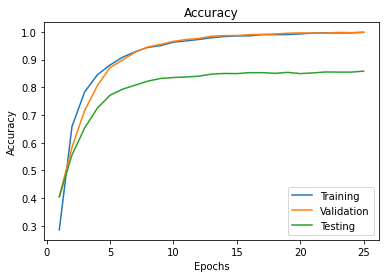

In [16]:
plt.plot(epochs, history.history['accuracy'], label="Training")
plt.plot(epochs, history.history['val_accuracy'], label="Validation")
plt.plot(epochs, accuracyArray, label="Testing")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig("Accuracy1.png")

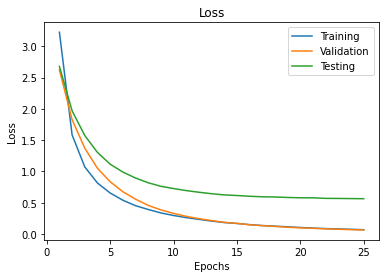

In [17]:
plt.plot(epochs, history.history['loss'], label="Training")
plt.plot(epochs, history.history['val_loss'], label="Validation")
plt.plot(epochs, lossArray, label="Testing")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.savefig("Loss1.png")

In [19]:
accuracyArray = []
lossArray = []

# vgg19 model

In [20]:
model2 = create_model(num_classes, create_vgg_model())
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 batch_normalization_204 (Ba  (None, 7, 7, 512)        2048      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 102)               52326     
                                                                 
Total params: 20,078,758
Trainable params: 4,772,966
Non-trainable params: 15,305,792
_________________________________________________________________


In [21]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1,factor=0.6, min_lr=0.000001)
epochs = 25
history2 = model2.fit(ds_train_processed, epochs=epochs, validation_data=ds_valid_processed, verbose=1,
                        callbacks=[TestCallback(ds_test_processed), learning_rate_reduction, early_stopping])

Epoch 1/25
21/21 [==============================] - 65s 3s/step - loss: 2.5942 - accuracy: 0.4475 - val_loss: 3.1463 - val_accuracy: 0.3371 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - 33s 2s/step - loss: 0.9727 - accuracy: 0.8173 - val_loss: 1.1655 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - 33s 1s/step - loss: 0.4546 - accuracy: 0.9267 - val_loss: 0.5534 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 4/25
21/21 [==============================] - 33s 1s/step - loss: 0.2023 - accuracy: 0.9831 - val_loss: 0.2678 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 5/25
21/21 [==============================] - 33s 1s/step - loss: 0.0791 - accuracy: 0.9993 - val_loss: 0.1746 - val_accuracy: 0.9985 - lr: 0.0010
Epoch 6/25
21/21 [==============================] - 33s 1s/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 0.1051 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 7/25
21/21 [==============================] - 33s 1s/step - loss: 0.0155 - a

In [22]:
res2 = model2.evaluate(ds_test_processed)
print("[Loss, Accuracy] = ", res2)

11/11 [==============================] - 10s 485ms/step - loss: 0.3966 - accuracy: 0.8999
[Loss, Accuracy] =  [0.39655768871307373, 0.89990234375]


In [23]:
epochs = list(range(1, epochs + 1))

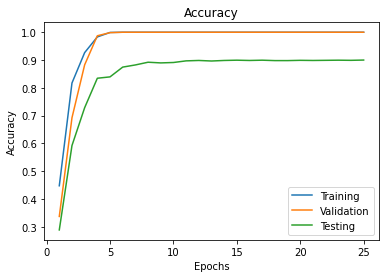

In [24]:
plt.plot(epochs, history2.history['accuracy'], label="Training")
plt.plot(epochs, history2.history['val_accuracy'], label="Validation")
plt.plot(epochs, accuracyArray, label="Testing")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.savefig("Accuracy2.png")

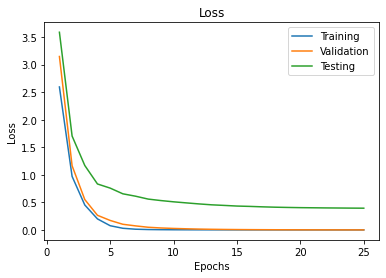

In [25]:
plt.plot(epochs, history2.history['loss'], label="Training")
plt.plot(epochs, history2.history['val_loss'], label="Validation")
plt.plot(epochs, lossArray, label="Testing")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.savefig("Loss2.png")